# Imaging Tutorial with the Sparse Modeling Technique

This notebook is a tutorial of synthesis imaging based on the sparse modeling technique using PRIISM. 
<b>PRIISM</b> is an imaging tool for radio interferometry based on the sparse modeling technique (<a href="https://github.com/tnakazato/priism" target="_blank" rel="noopener">PRIISM</a>: Python Module for Radio Interferometry Imaging with Sparse Modeling). 
In the tutorial, we try synthesis imaging for ALMA interferometry data using PRIISM. 

## ALMA Data : HL Tau

Sample data for the tutorial is the protoplanetary disk "<b>HL Tau</b>" observed at Band 6 with long baselines of ALMA 12m array as <a href="https://almascience.nao.ac.jp/alma-data/science-verification" target="_blank" rel="noopener">science verification</a>. 
The calibration infromation is obtained in <a href="https://casaguides.nrao.edu/index.php?title=ALMA2014_LBC_SVDATA#HL_Tau_-_Protoplanetary_Disk" target="_blank" rel="noopener">CASA Guide</a>, and the data can be downloaded from the link below: <br>
&emsp; <a href="https://alma-dl.mtk.nao.ac.jp/ftp/alma/sciver/HLTauBand6/HLTau_Band6_CalibratedData.tgz" target="_blank" rel="noopener">https://alma-dl.mtk.nao.ac.jp/ftp/alma/sciver/HLTauBand6/HLTau_Band6_CalibratedData.tgz</a>

## Setup PRIISM

Before you start the tutorial, you should install PRIISM and packages that PRIISM depends on, such as <code>casatools</code> and <code>casatasks</code>. <br>
Hereafter, we suppose that PRIISM was installed using Python <code>setuptools</code> combined with CASA 6 modular release in a virtual environment. 

### Activate Virtual Environment

The tutorial should be processed under the python virtual environment installed PRIISM. 
If the virtual environment is not activated yet, you should activate the virtual environment and set the python path. 
Please set the <code>activate</code> file with path and the python path for the virtual environment created by <code>venv</code>. 
It is necessary to modify these to match the PRIISM installation in your environment. <br>
If you already activate the virtual environment before Jupyter Notebook start, you can comment out the following commands.

In [ ]:
!source <virtual environment name with path>/bin/activate
import os, sys, pprint
sys.path.append('<virtual environment name with path>/lib/python3.8/site-packages')
sys.path.append('<virtual environment name with path>/lib/python3.8/site-packages/priism-0.11.3-py3.8.egg')
sys.path.append('<execution module path>/priism/runner')
#pprint.pprint(sys.path)

### Initialization PRIISM

PRIISM includes two modules <code>priism</code> and <code>priism.alma</code>. The former is a set of core functionalities and primitive interface while the later is high-level interface specific to ALMA data. You should import at least <code>priism.alma</code> module in this tutorial. <br>
And also, the execution module <code>runner</code> that allows us to easily run PRIISM is imported.

In [ ]:
import priism.alma
print(f'PRIISM version {priism.__version__}')
import runner

PRIISM version 0.11.3


Matplotlib figures are made to be displayed in the notebook.

In [ ]:
%matplotlib inline

## Data Preparation

### Download Data

Here, the sample visibility data mentioned above is downloaded. 
The data set is downloaded and extended. 
The compressed tar file includes calibrated measurement sets (MSs) and calibration tables for CASA. 

In [ ]:
import os
import subprocess

# download data
base_url = 'https://alma-dl.mtk.nao.ac.jp/ftp/alma/sciver/HLTauBand6/'
data_tgz = 'HLTau_Band6_CalibratedData.tgz'
data_dir = 'HLTau_Band6_CalibratedData'

if not os.path.exists(data_tgz):
    subprocess.run(['wget', base_url + data_tgz])
    print("Date download successful.")

if not os.path.exists(data_dir):
    subprocess.run(['tar', 'xf', data_tgz])
    print("Date extended tar successful.")

Date download successful.
Date extended tar successful.


### Preparation of Measurement Set

If you want, visibility channels in the MS data can be averaged to apply to PRIISM. 
Here, the task <code>split</code> in <code>casatasks</code>, that should have been installed as a dependency of PRIIS, split visivility data of the assigned target field and spectral window (spw), with averaging if needed. <br>

<code>orgvis</code> is a name of the calibrated MS that is downloaded as mentioned above. 
The MS data assigned in <code>vis</code> will be used in the subsequent steps. 
The details of the visibility (MS) data are outputted as "<code>*.listobs</code>" files.

In [ ]:
from casatasks import split, listobs

base_url = 'https://alma-dl.mtk.nao.ac.jp/ftp/alma/sciver/HLTauBand6/'
data_tgz = 'HLTau_Band6_CalibratedData.tgz'
data_dir = 'HLTau_Band6_CalibratedData'

orgvis = 'HLTau_B6cont.calavg'
vis = 'hltau_b6cont_spw0.ms'
field='0' # field ID
spw='0'   # spectral window (spw) ID
os.system('rm -rf '+vis)
split(vis=f'{data_dir}/{orgvis}', outputvis=vis,
      field=field, spw=spw, datacolumn='data')
info1=listobs(vis=f'{data_dir}/{orgvis}', listfile=orgvis+'.listobs', 
              verbose=False, overwrite=True)
info2=listobs(vis=vis, listfile=vis+'.listobs', 
              verbose=False, overwrite=True)
print("# Data split has finished.")

# Data split has finished.


In [ ]:
#!cat HLTau_B6cont.calavg.listobs | grep ALMA_RB_
!cat hltau_b6cont_spw0.ms.listobs | grep ALMA_RB_

  0      ALMA_RB_06#BB_1#SW-01#FULL_RES      4   TOPO  224750.000   -500000.000   2000000.0 224000.0000        1  XX  YY


## Image Configuration

Here, the parameters in the input visivility (MS) data and the output image are set. At first, the class <code>Session</code> is declared from the execution module <code>runner</code> mentioned above. <br>
In <code>setDataParam</code>, only single field data can be accepted now. <br>
In <code>setImageParam</code>, note that <code>nchan</code> should be 1. These limitation may be relaxed in the future. <br>
Total number of <code>ch</code> in the input visivility parameters (<code>setDataParam</code>) should be consistent with <code>nchan</code>&times;<code>width</code> in the output image parameters (<code>setImageParam</code>). 

In [ ]:
h=runner.Session(vis)
h.setDataParam(field='0', spw='0', ch='0~3')
h.setImageParam(imsize=[800, 800], cell=['0.005arcsec'],
                nchan=1, start=0, width=4)

#############################
(runner.Session): vis = hltau_b6cont_spw0.ms


## Direct Imaging

An image is created from the visibility (MS) data. There are two parameters for imaging: <code>L1</code> and <code>Ltsv</code>. They are hyper parameters for regularization terms. Once you give these parameters, you will obtain one image. 
To make execution duration short, max iteration is limited to <code>maxiter</code>. 
The resultant image is exported to FITS file named as <code>dimname</code>. <br>
That resulting image with these following parameters is scientifically optimized. You should perform cross-validation to obtain more reliable image.

In [ ]:
%%timeit -n 1 -r 1
%%capture --no-display capture_cv

dimname = 'hltau_b6cont_spw0.fits'
h.setImageParam(imname=dimname)
h.setSpParam(l1=1e5, ltsv=1e9, maxiter=100)
h.run(overwrite=True)
h.saveParam('hltau.dimg.param', overwrite=True)

7min 25s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Cross-Validation: Finding The Most Reliable Image

In the previous step, <code>L1</code> and <code>Ltsv</code> are treated as fixed parameters. In practice, however, these parameters must be optimized to obtain the most reliable image for given visibility data. PRIISM implements a cross validation for optimization. In general, cross validation is time-consuming process because it requires to solve the problem many times and we need to search broad range of L1-Ltsv parameter space. This step is a shorthand for cross validation. We will search only 4&times;4 parameter space (<code>L1_list</code> and <code>Ltsv_list</code>) and will perform 4-fold cross validation (default is 10-fold). 
<br>
The results of the cross-validation are outputted in "<code>cvname</code>/<code>cvname</code>.cvresult.dat". 
In the table in the file, the image provided from the L1-Ltsv pair with the smallest "MSE" should be the most reliable image. 
And also, the all cross-validation images are shown here, and the most reliable image is boxed in a red square. 
This most reliable image will be stored in "<code>cvname</code>/<code>cvname</code>.fits".

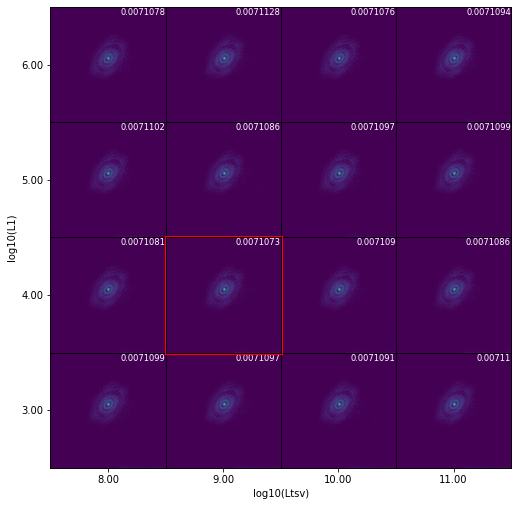

3h 25min 23s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [ ]:
%%timeit -n 1 -r 1
%%capture --no-display capture_cv

L1_list=[1e3, 1e4, 1e5, 1e6]
Ltsv_list=[1e8, 1e9, 1e10, 1e11]
num_fold = 4

cvname = 'hltau_b6cont_spw0.cv'
h.setSpParam(cvname=cvname, l1List=L1_list, ltsvList=Ltsv_list,
             maxiter=100, numFold=num_fold,
             optimizer='classical')
h.crossValidation(overwrite=True)

In [ ]:
print('# L1, ltsv, MSE ')
with open(cvname+'/'+cvname+'.cvresult.dat', "r") as f:
    next(f)
    for line in f:
        dat=line[:-1].split("\t")[0].split(',')
        print(f'{float(dat[0])},', f'{float(dat[1])},', f'{float(dat[2])}')

# L1, ltsv, MSE 
1000000.0, 100000000.0, 0.007107804861341253
100000.0, 100000000.0, 0.0071101889687499795
10000.0, 100000000.0, 0.007108140684804039
1000.0, 100000000.0, 0.007109855617026444
1000000.0, 1000000000.0, 0.007112776461261766
100000.0, 1000000000.0, 0.007108566501880626
10000.0, 1000000000.0, 0.007107305650891823
1000.0, 1000000000.0, 0.0071096953421547334
1000000.0, 10000000000.0, 0.007107602817572238
100000.0, 10000000000.0, 0.007109674917216459
10000.0, 10000000000.0, 0.007108950227271931
1000.0, 10000000000.0, 0.007109076883738387
1000000.0, 100000000000.0, 0.007109448319870617
100000.0, 100000000000.0, 0.007109894414765074
10000.0, 100000000000.0, 0.007108599488769835
1000.0, 100000000000.0, 0.007109960854888886


## Cross-Validation: Accelerating with Bayesian Optimization

The cross-validation method has an option to choose optimizer. Default optimizer is <code>'classical'</code> which evaluates each pair of <code>L1</code> and <code>Ltsv</code> in order to find the most reliable combination. In general, <code>'classical'</code> optimizer takes time because all combinations of given sets of <code>L1</code> and <code>Ltsv</code> must be evaluated. This makes practically difficult to search wide range of <code>L1</code> and <code>Ltsv</code>. To address this issue, we've introduced another optimizer, <code>'bayesian'</code>. The <code>'bayesian'</code> optimizer performs Bayesian optimization to reach the most reliable combination with less number of evaluation instead of evaluating individual hyperparameter pairs. Below is an example of obtaining the best result among 12&times;12 hyperparameters (144 pairs) with up to 15 evaluations, i.e. almost 1/10 of total number of combinations. You will see the same (or close) result to the one obtained by the <code>'classical'</code> optimizer. You can choose, or combine, these optimizers as needed to reach the best image. 
<br>
Here, the cross-validation images with the bayesian optimizer are shown, and the most reliable image is boxed in a red square. The most reliable image will be stored in "<code>cvbyname</code>/<code>cvbyname</code>.fits".

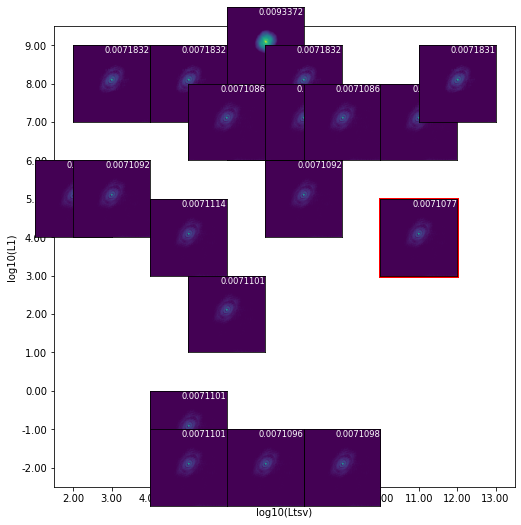

5h 18min 37s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [ ]:
%%timeit -n 1 -r 1
%%capture --no-display capture_cv

L1_list = [1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9]
Ltsv_list =  [1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9, 1e10, 1e11, 1e12, 1e13]
num_fold = 4

cvbyname = 'hltau_b6cont_spw0.cv_bay'
h.setSpParam(cvname=cvbyname, l1List=L1_list, ltsvList=Ltsv_list,
             maxiter=100, numFold=num_fold,
             optimizer='bayesian', bayesopt_maxiter=15)
h.crossValidation(overwrite=True)

## Processing using a Parameter File

Imaging and cross-validation can be processed using parameters stored in a parameter file. 
For reading the parameter file, <code>loadParam</code> is used. 
And also, the used parameters can be stored by <code>saveParam</code> in a parameter file of <code>*.param</code>. 
(The parameters in cross-validations are automatically stored, such as "<code>cvname</code>/<code>cvname</code>.param".) 
You manually make the parameter file and can apply that for imaging and cross-validation as well. <br>

<br>
For example, you can perform imaging or cross-validation using the parameter file "test.param" as follows,
<pre style="width: 350px; margin: 10px; padding: solid 3px; background-color: #ffffe0;">
<code style="background-color: #ffffe0;">hh=runner.Session.loadParam('test.param')</code>
<code style="background-color: #ffffe0;">hh.run(overwrite=True)</code>
</pre>
or
<pre style="width: 350px; margin: 10px; padding: solid 3px; background-color: #ffffe0;">
<code style="background-color: #ffffe0;">hh=runner.Session.loadParam('test.param')</code>
<code style="background-color: #ffffe0;">hh.crossValidation(overwrite=True)</code>
</pre>

The sample of the parameter file for the classical cross-validation is as follows,
<pre style="width: 500px; margin: 10px; padding: solid 3px; background-color: #ffffe0;">
<code style="background-color: #ffffe0;">vis:            hltau_b6cont_spw0.ms
field:          0
spw:            0
ch:             0~3
datacolumn:     data
imname:         hltau_b6cont_spw0.fits
imsize:         [800, 800]
cell:           ['0.005arcsec']
nchan:          1
start:          0
width:          4
cvname:         hltau_b6cont_spw0.cv
solver:         mfista_nufft
l1:             100000.0
ltsv:           1000000000.0
maxiter:        100
numFold:        4
imagePolicy:    full
l1List:         [1000.0, 10000.0, 100000.0, 1000000.0]
ltsvList:       [100000000.0, 1000000000.0, 10000000000.0, 100000000000.0]
optimizer:      classical
bayesopt_maxiter:       15</code>
</pre>

In [ ]:
#%%timeit -n 1 -r 1
#%%capture --no-display capture_cv
#hh=runner.Session.loadParam('hltau_b6cont_spw0.cv/hltau_b6cont_spw0.cv.param')
#hh.crossValidation(overwrite=True)

## Display Final Image

The created image is displayed here using the <code>matplotlib</code> modular. <br>
By default, if the final image with classical cross-validation exist, that is shown. Here, the area of 500&times;500 pixels around central region of the image is shown. 

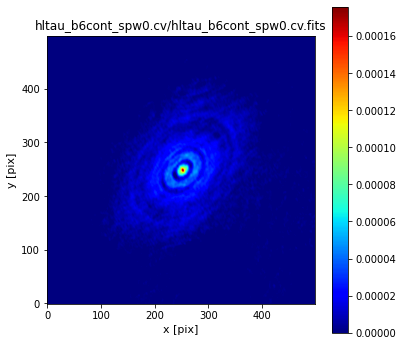

In [ ]:
%matplotlib inline
import numpy as np
from astropy.io import fits
from matplotlib import pyplot as plt

imname1 = dimname
imname2 = cvname+'/'+cvname+'.fits'
imname3 = cvbyname+'/'+cvbyname+'.fits'
imname = imname1
if os.path.isfile(imname2):
    imname = imname2
elif os.path.isfile(imname3):
    imname = imname3

pixs=800; imwd=500; exwd=np.int((pixs-imwd)/2)
ff,aa=plt.subplots(1,1, figsize=(6,6))
#im=aa.imshow(fits.getdata(imname)[0,0,exwd:((pixs-1)-exwd),exwd:((pixs-1)-exwd)], 
im=aa.imshow(fits.getdata(imname)[0,0,exwd+40:((pixs-1)-exwd)+40,exwd:((pixs-1)-exwd)], 
             origin='lower', cmap='jet')
#             vmin=0, vmax=0.0005, origin='lower', cmap='jet')
cbar=plt.colorbar(im, ax=aa)
aa.set_title(imname)
aa.set_xlabel("x [pix]",size=11)
aa.set_ylabel("y [pix]",size=11)
plt.savefig(dimname.replace('fits','png'), bbox_inches="tight", pad_inches=0.05)
plt.show()